In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [32]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [33]:
learning_rate = 0.9
total_epoch = 30
n_input = 2
n_step = 28
n_hidden = 10
n_class = 2
target_names = ['Langtitude', 'Longtitude']

In [34]:
x_data = np.array([[110, 26.000, 29.000], [115,29.000,29.400], [135,29.000,29.400], [145,23.000,29.500], 
                  [145, 26.000, 29.500], [150, 27.000, 29.500], [160, 27.000, 29.500], [175, 26.000, 29.100],
                  [145, 30.000, 29.500], [190, 25.000, 28.700], [165, 25.000, 28.600], [165, 27.000, 29.000],
                  [170, 35.000, 29.400], [170, 44.000, 28.700], [190, 56.000, 28.900], [215, 61.000, 28.600],
                  [210, 56.000, 28.900], [215, 57.000, 29.200], [205, 55.000, 29.000], [205, 52.000, 29.200],
                  [185, 50.000, 29.100], [205, 56.000, 29.100], [200, 47.000, 28.700], [195, 49.000, 29.000], [195, 61.000, 29.000]]) #입력
y_data = np.array([[15.8, 158.1],[15.6, 156.4], [15.2, 154.6], [14.7, 153.1], [14.3, 152.0], [14.4, 151.4],
                  [14.5, 150.1], [14.4, 148.7], [14.5, 146.8], [13.8, 145.2], [14.5, 144.6], [14.4, 143.5],
                  [14.3, 141.6], [14.2, 140.6], [13.6, 139.2], [13.5, 138.0], [13.7, 137.2], [14.8, 136.6],
                  [15.5, 135.9], [16.1, 135.4], [16.8, 134.7], [17.7, 133.3], [18.5, 132.5], [19.7, 131.5], [20.8, 130.4]]) #출력
tf.reset_default_graph()

num_data = len(x_data)
num_train = int(learning_rate * num_data)
num_test = num_data - num_train

x_train = x_data[0 : num_train]
x_test = x_data[num_train : ]

y_train = y_data[0: num_train]
y_test = y_data[num_train :]

#입력 신호의 수
num_x_signals = x_data.shape[1]
#출력 신호의 수
num_y_signals = y_data.shape[1]

In [35]:
#데이터들을 -1~1 사이로 조정
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(x_train_scaled.shape)
print(y_train_scaled.shape)

(22, 3)
(22, 2)


In [36]:
#배치 사이즈 설정
def batch_generator(batch_size, sequence_length): 
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape = x_shape, dtype = np.float16)
        
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape = y_shape, dtype = np.float16)
        
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            
            x_batch[i] = x_train_scaled[idx : idx+sequence_length]
            y_batch[i] = y_train_scaled[idx : idx+sequence_length]
            
        yield(x_batch, y_batch)

In [37]:
batch_size = 256
sequence_length = 15
#8 * 7 * 8

generator = batch_generator(batch_size = batch_size, sequence_length = sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 15, 3)
(256, 15, 2)


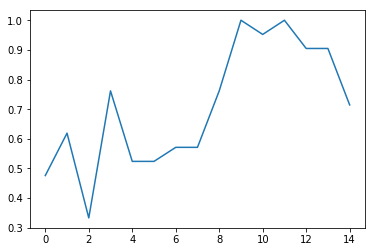

In [38]:
#입력 신호 출력
batch = 0
signal = 0
seq = x_batch[batch, :, signal]
plt.plot(seq)

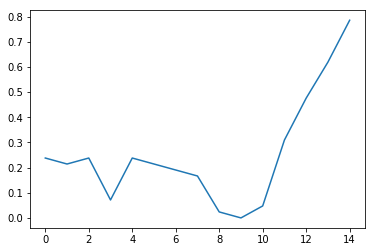

In [39]:
#출력 신호 출력
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [40]:
#모델 테스트 시 성능이 향상되는 경우에만 가중치 저장
validation_data = (np.expand_dims(x_test_scaled, axis = 0),
                   np.expand_dims(y_test_scaled, axis = 0))

In [41]:
#RNN 생성
model = Sequential()
model.add(GRU(units = 512, return_sequences = True, input_shape = (None, num_x_signals,)))
model.add(Dense(num_y_signals, activation = 'sigmoid'))

if False:
    from tensorflow.python.keras.initializers import RandomUniform
    init = RandomUniform(minval = -0.05, maxval = 0.05)
    model.add(Dense(num_y_signals, activation = 'linear', kernel_initializer = init))

Instructions for updating:
Colocations handled automatically by placer.


In [42]:
#손실 함수
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    loss = tf.losses.mean_squared_error(labels = y_true_slice, predictions = y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [43]:
#모델 컴파일
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         792576    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 793,602
Trainable params: 793,602
Non-trainable params: 0
_________________________________________________________________


In [44]:
#callback functions
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint, monitor = 'val_loss', 
                                      verbose = 1, save_weights_only = True, save_best_only = True)
callback_early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
callback_tensorboard = TensorBoard(log_dir = './23_logs/',
                                  histogram_freq = 0,
                                  write_graph = False)
callback_reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                      factor = 0.1,
                                      min_lr = 1e-4,
                                      patience = 0,
                                      verbose = 1)
callbacks = [callback_early_stopping,
            callback_checkpoint,
            callback_tensorboard,
            callback_reduce_lr]

In [45]:
#성능 테스트
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 0s 363ms/sample - loss: 0.0000e+00
loss (test-set): 0.0


In [57]:
#예측값과 실제 값을 그래프로 표현
def plot_comparison(start_idx, length = 100, train = True):
    if train:
        x = x_train_scaled
        y_true = y_train
    else:
        x = x_test_scaled
        y_true = y_test
    end_idx = start_idx + length
    
    y_true = y_true[start_idx:end_idx]
    x = np.expand_dims(x, axis = 0)
    y_pred = model.predict(x)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        plt.figure(figsize = (15, 5))
        plt.plot(signal_true, label = 'true')
        plt.plot(signal_pred, label = 'pred')
        p = plt.axvspan(0, warmup_steps, facecolor = 'black', alpha = 0.15)
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

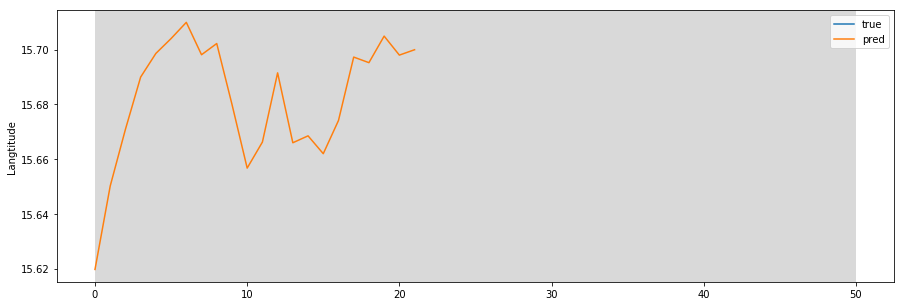

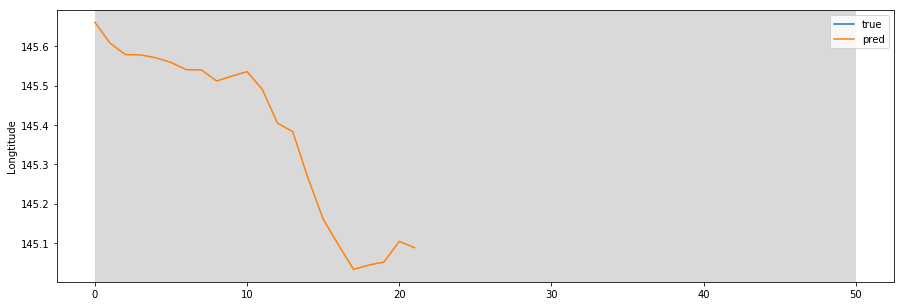

In [58]:
plot_comparison(start_idx=100000, length=1000, train=True)